# CNN and Gans with MNIST

## Part-1 : CNN

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [8]:
(trainx,trainy),(testx,testy)=mnist.load_data()

11501568/11490434 [==============================] - 14s 1us/step


In [9]:
print trainx.shape,trainy.shape
print testx.shape,testy.shape

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


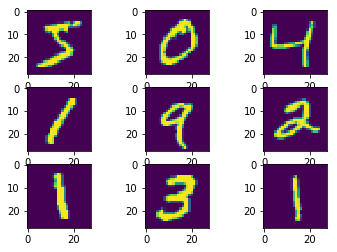

In [12]:
%matplotlib inline
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(trainx[i])

#### Change train data into single channel of 28*28 pixels

In [13]:
trainx = trainx.reshape((trainx.shape[0],28,28,1))
testx = testx.reshape((testx.shape[0],28,28,1))

#### One hot encoding of the y category labels from classes in 1-10

In [15]:
from keras.utils import to_categorical
trainy = to_categorical(trainy)
testy = to_categorical(testy)

#### Pixel data in the range of 0-255 normalize it between 0-1

In [17]:
#convert to float
trainx_norm = trainx.astype('float32')
testx_norm =  testx.astype('float32')

#### Normalize between 0-1

In [18]:
trainx_norm = trainx_norm/255.0
testx_norm = testx_norm/255.0

#### Feature Extraction (frontend)

In [22]:
from keras.models import Sequential
model=Sequential()

In [24]:
from keras.layers import Conv2D
model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))

In [25]:
from keras.layers import MaxPooling2D
model.add(MaxPooling2D((2, 2)))

In [26]:
from keras.layers import Flatten
model.add(Flatten())

In [28]:
from keras.layers import Dense
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

#### Output layer

In [29]:
model.add(Dense(10, activation='softmax'))

#### stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9

In [30]:
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

In [31]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### 5 fold cross validation

In [32]:
from sklearn.model_selection import KFold
kfold = KFold(5, shuffle=True, random_state=1)

In [35]:
histories = list()
scores = list()
for train_ix, test_ix in kfold.split(trainx_norm):
    trainX, trainY, testX, testY = trainx_norm[train_ix], trainy[train_ix], trainx_norm[test_ix], trainy[test_ix]
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    _, acc = model.evaluate(testX, testY, verbose=0)
    print acc*100.0
    scores.append(acc)
    histories.append(history)
print histories,scores

98.73333333333333
99.83333333333333
99.99166666666667
100.0
100.0
[<keras.callbacks.History object at 0x7f116f480c10>, <keras.callbacks.History object at 0x7f118109e310>, <keras.callbacks.History object at 0x7f116f4809d0>, <keras.callbacks.History object at 0x7f117b12df90>, <keras.callbacks.History object at 0x7f116f480950>] [0.9873333333333333, 0.9983333333333333, 0.9999166666666667, 1.0, 1.0]


In [71]:
model.summary()

ValueError: This model has never been called, this its weights have not yet been created, so no summary can be displayed. Build the model first (e.g. by calling it on some test data).

#### Learning curve diagnostics

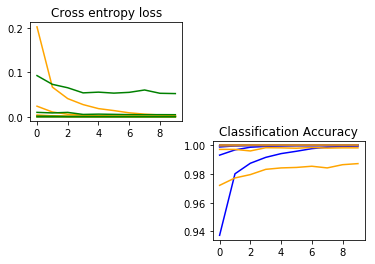

In [54]:
for i in range(len(histories)):
    plt.subplot(221)
    plt.title('Cross entropy loss')
    plt.plot(histories[i].history['loss'],color="orange",label="train")
    plt.plot(histories[i].history['val_loss'],color="green",label="test")
    
    plt.subplot(224)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['acc'], color='blue', label='train')
    plt.plot(histories[i].history['val_acc'], color='orange', label='test')
plt.show()
    

#### classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation

Accuracy: 99.71166666666666 0.49327702381341865 5


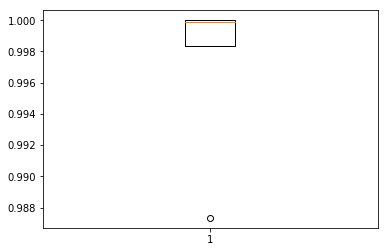

In [60]:
from numpy import mean,std
print 'Accuracy:',mean(scores)*100, std(scores)*100, len(scores)
plt.boxplot(scores)
plt.show()

## Part-2 : GAN

### Discriminator

#### 2 convolutional layers, small kernel size 3, stride of 2

In [62]:
gan_model = Sequential()
gan_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))

#### Best practices are using : LeakyRelU, adam sgd and dropout

In [65]:
from keras.layers import Dropout
from keras.layers import LeakyReLU
gan_model.add(LeakyReLU(alpha=0.2))
gan_model.add(Dropout(0.4))
gan_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
gan_model.add(LeakyReLU(alpha=0.2))
gan_model.add(Dropout(0.4))
gan_model.add(Flatten())
gan_model.add(Dense(1, activation='sigmoid'))

In [67]:
from keras.optimizers import Adam
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

In [69]:
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
__________

In [91]:
from numpy.random import randint
from numpy import ones
from numpy.random import rand
from numpy import zeros
for i in range(100):
    ix = randint(0, trainx_norm.shape[0], 128)
    X_real = trainx_norm[ix]
    y_real = ones((128, 1))

    _, real_acc = gan_model.train_on_batch(X_real, y_real)

    X_fake = rand(28 * 28 * 128)
    # reshape into a batch of grayscale images
    X_fake = X_fake.reshape((128, 28, 28, 1))
    # generate 'fake' class labels (0)
    y_fake = zeros((128, 1))
    _, fake_acc = gan_model.train_on_batch(X_fake, y_fake)
    
    print i+1,'real',real_acc*100,'fake',fake_acc*100

1 real 35.9375 fake 84.375
2 real 26.5625 fake 93.75
3 real 29.6875 fake 97.65625
4 real 32.8125 fake 100.0
5 real 35.9375 fake 100.0
6 real 35.15625 fake 100.0
7 real 38.28125 fake 100.0
8 real 42.1875 fake 100.0
9 real 36.71875 fake 100.0
10 real 44.53125 fake 100.0
11 real 48.4375 fake 100.0
12 real 41.40625 fake 100.0
13 real 48.4375 fake 100.0
14 real 60.9375 fake 100.0
15 real 55.46875 fake 100.0
16 real 57.03125 fake 100.0
17 real 67.96875 fake 100.0
18 real 64.0625 fake 100.0
19 real 69.53125 fake 100.0
20 real 78.125 fake 100.0
21 real 73.4375 fake 100.0
22 real 84.375 fake 100.0
23 real 81.25 fake 100.0
24 real 86.71875 fake 100.0
25 real 93.75 fake 100.0
26 real 95.3125 fake 100.0
27 real 94.53125 fake 100.0
28 real 92.1875 fake 100.0
29 real 98.4375 fake 100.0
30 real 96.09375 fake 100.0
31 real 99.21875 fake 100.0
32 real 97.65625 fake 100.0
33 real 98.4375 fake 100.0
34 real 100.0 fake 100.0
35 real 100.0 fake 100.0
36 real 99.21875 fake 100.0
37 real 100.0 fake 100.0
38 